## NLTK NE Chunker
In this notebook we explore NLTK ne_chunk for Named Entity Recognition. We go on to implement our own Music Instruments recognizer.

In [1]:
from nltk import word_tokenize, pos_tag, ne_chunk, conlltags2tree, tree2conlltags
from nltk.corpus import stopwords
import re

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Test a sentence
sentence = "Barack stands at the Oval inside White House"

In [3]:
# NLTK ne_chunk works on part-of-speech tags
chunked = ne_chunk(pos_tag(word_tokenize(sentence)))
print(chunked)

(S
  (GPE Barack/NNP)
  stands/VBZ
  at/IN
  the/DT
  (FACILITY Oval/NNP)
  inside/IN
  (FACILITY White/NNP House/NNP))


In [4]:
# conll tags can be generated directly from the ne_tree returned by ne_chunk. we may use this functionality in future.
from nltk.chunk import conlltags2tree, tree2conlltags
ne_tree = ne_chunk(pos_tag(word_tokenize(sentence)))
iob_tagged = tree2conlltags(ne_tree)

In [5]:
print(iob_tagged)

[('Barack', 'NNP', 'B-GPE'), ('stands', 'VBZ', 'O'), ('at', 'IN', 'O'), ('the', 'DT', 'O'), ('Oval', 'NNP', 'B-FACILITY'), ('inside', 'IN', 'O'), ('White', 'NNP', 'B-FACILITY'), ('House', 'NNP', 'I-FACILITY')]


In [6]:
ne_tree = conlltags2tree(iob_tagged)
print(ne_tree)

(S
  (GPE Barack/NNP)
  stands/VBZ
  at/IN
  the/DT
  (FACILITY Oval/NNP)
  inside/IN
  (FACILITY White/NNP House/NNP))


## Train custom NER 

In [7]:
# load the wiki extracted data
parent_dir = '/Users/saurabh/workspace/datasets/wikimusic/'

# load instruments_line.csv
mi_f_name = parent_dir + "instruments_line1.csv"
mi_df = pd.read_csv(mi_f_name, delimiter='|')
mi_df.head(2)
mi_df.count()

title    604
line1    604
dtype: int64

In [8]:
stopset = set(stopwords.words('english'))
music_words = set(mi_df["title"].str.lower().values)
# music_words

In [9]:
# unused
# adapted from https://nlpforhackers.io/named-entity-extraction/
# to created conll type tags for our custom tag "MUSIC"
def to_conll_iob(annotated_sentence):
    """
    `annotated_sentence` = list of triplets [(w1, t1, iob1), ...]
    Transform a pseudo-IOB notation: O, PERSON, PERSON, O, O, LOCATION, O
    to proper IOB notation: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    """
    proper_iob_tokens = []
    for idx, annotated_token in enumerate(annotated_sentence):
        (tag, word), ner = annotated_token
        try:
            if ner != 'O':
                if idx == 0:
                    ner = "B-" + ner
                elif annotated_sentence[idx - 1][1] == ner:
                    ner = "I-" + ner
                else:
                    ner = "B-" + ner
            proper_iob_tokens.append(((tag, word), ner))
        except:
            print("exception")
            print(annotated_sentence)
            print(annotated_token)
    return proper_iob_tokens

In [10]:
# regex to match any title such as 'Clave (rhythm)' to remove the bracket and the words inside.
in_brackets = r'\([^)]*\)'
in_heading = r'\==[^=]*\=='

In [11]:
# for annotating wiki extracted data in a format that ne_chunk would understand
def annotate_data(row):
    retval = []
    title, line1 = row
    title = re.sub(in_brackets, '', title).strip()
    line1 = re.sub(in_heading, '', line1).strip()
    # code an effective model that for titles - include word stem, similar words
    title_tkns = word_tokenize(title.lower())
    # title_tkns = [title.lower()]
    tkns = word_tokenize(line1)
    indices = []
    for idx, tkn in enumerate(tkns):
        # code an effective similarity function
        if (tkn.lower() in title_tkns and tkn.lower() not in stopset) or tkn.lower() in music_words or ( 0 < idx < (len(tkns) - 1) and \
            (" ".join(tkns[idx -1 : idx + 1]).lower() in music_words \
             or " ".join(tkns[idx : idx + 2]).lower() in music_words \
             or " ".join(tkns[idx -1 : idx + 2]).lower() in music_words) \
                                                                      ):
            indices.append(idx)
    tagged = pos_tag(tkns)
    for idx, tagged_tokens in enumerate(tagged):
        if idx not in indices:
            retval.append((tagged_tokens, 'O'))
        else:
            retval.append((tagged_tokens, 'MUSIC'))
    return retval

In [12]:
# pos tagging
mi_df["annotated"] = mi_df.apply(annotate_data, axis=1)
mi_df["annotated"] = mi_df["annotated"].apply(to_conll_iob)
mi_df.head(2)

,title,line1,annotated
0,Agung a tamlang,The Agung a Tamlang is a type of Philippine sl...,"[((The, DT), O), ((Agung, NNP), B-MUSIC), ((a,..."
1,Slit drum,A slit drum is a hollow percussion instrument,"[((A, DT), O), ((slit, NN), B-MUSIC), ((drum, ..."


In [13]:
# mi_df["annotated"] = mi_df["annotated"].apply(to_conll_iob)
# mi_df.head(2)
mi_df.loc[:0, "annotated"].values

array([list([(('The', 'DT'), 'O'), (('Agung', 'NNP'), 'B-MUSIC'), (('a', 'DT'), 'I-MUSIC'), (('Tamlang', 'NNP'), 'I-MUSIC'), (('is', 'VBZ'), 'O'), (('a', 'DT'), 'O'), (('type', 'NN'), 'O'), (('of', 'IN'), 'O'), (('Philippine', 'NNP'), 'O'), (('slit', 'NN'), 'B-MUSIC'), (('drum', 'NN'), 'I-MUSIC'), (('made', 'VBN'), 'O'), (('of', 'IN'), 'O'), (('hollowed', 'VBN'), 'O'), (('out', 'RP'), 'O'), (('bamboo', 'NN'), 'O'), (('in', 'IN'), 'O'), (('imitation', 'NN'), 'O'), (('of', 'IN'), 'O'), (('the', 'DT'), 'O'), (('real', 'JJ'), 'O'), (('agung', 'NN'), 'B-MUSIC')])],
      dtype=object)

In [14]:
# split the data into train and test set
msk = np.random.rand(len(mi_df)) < 0.8
train = mi_df[msk]
test = mi_df[~msk]
print(len(train))
print(len(test))

479
125


In [15]:
# adapted from https://nlpforhackers.io/named-entity-extraction/
# This is the custom trainer built on top of ChunkParserI provided by NLTK
import pickle
from collections import Iterable
from nltk.tag import ClassifierBasedTagger
from nltk.chunk import ChunkParserI
 
 
class NamedEntityChunker(ChunkParserI):
    def __init__(self, train_sents, **kwargs):
        assert isinstance(train_sents, Iterable)
 
        self.feature_detector = features
        self.tagger = ClassifierBasedTagger(
            train=train_sents,
            feature_detector=features,
            **kwargs)
 
    def parse(self, tagged_sent):
        chunks = self.tagger.tag(tagged_sent)
        return chunks

In [16]:
# adapted from https://nlpforhackers.io/named-entity-extraction/
# The features that are extracted by custom trainer
import string
from nltk.stem.snowball import SnowballStemmer
 
 
def features(tokens, index, history):
    """
    `tokens`  = a POS-tagged sentence [(w1, t1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
 
    # init the stemmer
    stemmer = SnowballStemmer('english')
 
    # Pad the sequence with placeholders
    tokens = [('[START2]', '[START2]'), ('[START1]', '[START1]')] + list(tokens) + [('[END1]', '[END1]'), ('[END2]', '[END2]')]
    history = ['[START2]', '[START1]'] + list(history)
 
    # shift the index with 2, to accommodate the padding
    index += 2
 
    word, pos = tokens[index]
    prevword, prevpos = tokens[index - 1]
    prevprevword, prevprevpos = tokens[index - 2]
    nextword, nextpos = tokens[index + 1]
    nextnextword, nextnextpos = tokens[index + 2]
    previob = history[index - 1]
    contains_dash = '-' in word
    contains_dot = '.' in word
    allascii = all([True for c in word if c in string.ascii_lowercase])
 
    allcaps = word == word.capitalize()
    capitalized = word[0] in string.ascii_uppercase
 
    prevallcaps = prevword == prevword.capitalize()
    prevcapitalized = prevword[0] in string.ascii_uppercase
 
    nextallcaps = prevword == prevword.capitalize()
    nextcapitalized = prevword[0] in string.ascii_uppercase
 
    return {
        'word': word,
        'lemma': stemmer.stem(word),
        'pos': pos,
        'all-ascii': allascii,
 
        'next-word': nextword,
        'next-lemma': stemmer.stem(nextword),
        'next-pos': nextpos,
 
        'next-next-word': nextnextword,
        'nextnextpos': nextnextpos,
 
        'prev-word': prevword,
        'prev-lemma': stemmer.stem(prevword),
        'prev-pos': prevpos,
 
        'prev-prev-word': prevprevword,
        'prev-prev-pos': prevprevpos,
 
        'prev-iob': previob,
 
        'contains-dash': contains_dash,
        'contains-dot': contains_dot,
 
        'all-caps': allcaps,
        'capitalized': capitalized,
 
        'prev-all-caps': prevallcaps,
        'prev-capitalized': prevcapitalized,
 
        'next-all-caps': nextallcaps,
        'next-capitalized': nextcapitalized,
    }

In [17]:
# train cutome NER
chunker = NamedEntityChunker(train["annotated"].values.tolist())

In [18]:
# test one sentence
chunker.parse(pos_tag(word_tokenize("Do you know once I was aggesively enraged to played a slit drum?")))

[(('Do', 'VB'), 'B-MUSIC'),
 (('you', 'PRP'), 'I-MUSIC'),
 (('know', 'VB'), 'I-MUSIC'),
 (('once', 'RB'), 'I-MUSIC'),
 (('I', 'PRP'), 'I-MUSIC'),
 (('was', 'VBD'), 'I-MUSIC'),
 (('aggesively', 'RB'), 'I-MUSIC'),
 (('enraged', 'VBN'), 'O'),
 (('to', 'TO'), 'O'),
 (('played', 'VB'), 'O'),
 (('a', 'DT'), 'O'),
 (('slit', 'NN'), 'B-MUSIC'),
 (('drum', 'NN'), 'I-MUSIC'),
 (('?', '.'), 'O')]

In [19]:
# compute precision per label of custom NER Tagger
def compute_precision(test_truth, test_pred):
    count_truth = 0
    count_pred = 0
    count = 0
    for i in range(len(test)):
        tags = test_pred[i]
        true_tags = test_truth[i]
        accurate = True
        count_false = 0
        count_all = 0.000001
        for tag, true_tag in zip(tags, true_tags):
            if "MUSIC" in true_tag[1] :
                count_truth += 1
                count_all += 1
                if "MUSIC" not in tag[1]:
                    accurate = False
                    count_false += 1 
                else:
                    count_pred += 1
        accurate = accurate or count_false/count_all <= 0.5
        if accurate:
            count += 1
#     print(count)
#     print(count/len(test_truth))
    return count_truth, count_pred, count_pred/count_truth, count/len(test_truth)

In [20]:
test_truth = test["annotated"].values.tolist()
test_pred = [chunker.parse(pos_tag(word_tokenize(sent))) for sent in test["line1"].values.tolist()]
compute_precision(test_truth, test_pred)

(288, 259, 0.8993055555555556, 0.944)

In [222]:
compute_precision(test_truth, test_pred)

(5507, 1212, 0.22008353005266024, 0.27)

In [21]:
large_corpus_fname = parent_dir + "instruments.csv"
mi_large_df = pd.read_csv(large_corpus_fname, delimiter='|')
mi_large_df = mi_large_df[["title", "content"]]
print(mi_large_df.head(2))

             title                                            content
0  Agung a tamlang  The Agung a Tamlang is a type of Philippine sl...
1        Slit drum  A slit drum is a hollow percussion instrument....


In [22]:
strip_unwanted_chars = lambda txt: re.sub(in_brackets, '', txt).strip()
titles = mi_large_df["title"].apply(strip_unwanted_chars)
parent_dictionary = set(titles.values.tolist())

In [23]:
# pos tagging
mi_large_df["annotated"] = mi_large_df.apply(annotate_data, axis=1)
mi_large_df["annotated"] = mi_large_df["annotated"].apply(to_conll_iob)
mi_large_df.head(3)

,title,content,annotated
0,Agung a tamlang,The Agung a Tamlang is a type of Philippine sl...,"[((The, DT), O), ((Agung, NNP), B-MUSIC), ((a,..."
1,Slit drum,A slit drum is a hollow percussion instrument....,"[((A, DT), O), ((slit, NN), B-MUSIC), ((drum, ..."
2,Balafon,The balafon is a kind of xylophone or percussi...,"[((The, DT), O), ((balafon, NN), B-MUSIC), ((i..."


In [24]:
mi_large_df["annotated"].iloc[0]

[(('The', 'DT'), 'O'),
 (('Agung', 'NNP'), 'B-MUSIC'),
 (('a', 'DT'), 'I-MUSIC'),
 (('Tamlang', 'NNP'), 'I-MUSIC'),
 (('is', 'VBZ'), 'O'),
 (('a', 'DT'), 'O'),
 (('type', 'NN'), 'O'),
 (('of', 'IN'), 'O'),
 (('Philippine', 'NNP'), 'O'),
 (('slit', 'NN'), 'B-MUSIC'),
 (('drum', 'NN'), 'I-MUSIC'),
 (('made', 'VBN'), 'O'),
 (('of', 'IN'), 'O'),
 (('hollowed', 'VBN'), 'O'),
 (('out', 'RP'), 'O'),
 (('bamboo', 'NN'), 'O'),
 (('in', 'IN'), 'O'),
 (('imitation', 'NN'), 'O'),
 (('of', 'IN'), 'O'),
 (('the', 'DT'), 'O'),
 (('real', 'JJ'), 'O'),
 (('agung', 'NN'), 'B-MUSIC'),
 (('.', '.'), 'O'),
 (('Pitch', 'NN'), 'O'),
 (('is', 'VBZ'), 'O'),
 (('determined', 'VBN'), 'O'),
 (('by', 'IN'), 'O'),
 (('the', 'DT'), 'O'),
 (('length', 'NN'), 'O'),
 (('and', 'CC'), 'O'),
 (('depth', 'NN'), 'O'),
 (('of', 'IN'), 'O'),
 (('the', 'DT'), 'O'),
 (('slit', 'NN'), 'O'),
 (('.', '.'), 'O'),
 (('The', 'DT'), 'O'),
 (('agung', 'NN'), 'B-MUSIC'),
 (('a', 'DT'), 'I-MUSIC'),
 (('tamlang', 'NN'), 'I-MUSIC'),
 (('is

In [25]:
# split the data into train and test set
msk = np.random.rand(len(mi_large_df)) < 0.8
train = mi_large_df[msk]
test = mi_large_df[~msk]
print(len(train))
print(len(test))

492
112


In [26]:
l_chunker = NamedEntityChunker(train["annotated"].values.tolist())

In [28]:
from joblib import dump, load
dump(l_chunker, 'mner.joblib')

['mner.joblib']

In [30]:
l_chunker = load('mner.joblib')

In [31]:
test_truth = test["annotated"].values.tolist()
test_pred = [l_chunker.parse(pos_tag(word_tokenize(sent))) for sent in test["content"].values.tolist()]
compute_precision(test_truth, test_pred)

(8132, 1643, 0.20204131824889326, 0.1875)

In [32]:
# test_sent = "Rumba clave is the key pattern used in Cuban rumba. Use of the triple-pulse form of rumba clave in Cuba can be traced back to the iron bell (ekón) part in abakuá music"
# l_chunker.parse(pos_tag(word_tokenize(test_sent)))

In [33]:
true_labels, correct_preds, ratio_precise, ratio_doc_precise = compute_precision(test_truth, test_pred)
print("Total number of tags: {} \nTotal number of tags recognized: {} \nRatio of predicted tags to true tags: {} \nRatio of documents identified correctly: {}".format(true_labels, correct_preds, ratio_precise, ratio_doc_precise))

Total number of tags: 8132 
Total number of tags recognized: 1643 
Ratio of predicted tags to true tags: 0.20204131824889326 
Ratio of documents identified correctly: 0.1875


## Relationship Extraction

In [34]:
from nltk.sem.relextract import tree2semi_rel, semi_rel2reldict
from nltk.sem.relextract import rtuple
import nltk

In [89]:
sentence = "The Agung a Tamlang is a type of Philippine slit drum made of hollowed out bamboo in imitation of the real agung. The balafon is a kind of xylophone or percussion idiophone which plays melodic tunes, and usually has between 16 and 27 keys. It has been played in Africa since the 12th century according to oral stories; it originated in Mali, according to the Manding history narrated by the griots."
chunked = ne_chunk(pos_tag(word_tokenize(sentence)))
tags = [(w, t, c) for ((w, t), c) in l_chunker.parse(pos_tag(word_tokenize(sentence)))]
chunked_l = conlltags2tree(tags)
# print(chunked_l)

In [90]:
pairs = tree2semi_rel(chunked_l)

In [91]:
reldicts = semi_rel2reldict(pairs)
print(reldicts)

[defaultdict(<class 'str'>, {'lcon': 'The/DT', 'subjclass': 'MUSIC', 'subjtext': 'Agung/NNP a/DT', 'subjsym': 'agung_a', 'filler': '', 'untagged_filler': '', 'objclass': 'MUSIC', 'objtext': 'Tamlang/NNP', 'objsym': 'tamlang', 'rcon': 'is/VBZ a/DT type/NN of/IN Philippine/NNP'}), defaultdict(<class 'str'>, {'lcon': '', 'subjclass': 'MUSIC', 'subjtext': 'Tamlang/NNP', 'subjsym': 'tamlang', 'filler': 'is/VBZ a/DT type/NN of/IN Philippine/NNP', 'untagged_filler': 'is a type of Philippine', 'objclass': 'MUSIC', 'objtext': 'slit/NN drum/NN', 'objsym': 'slit_drum', 'rcon': 'made/VBN of/IN hollowed/VBN out/RP bamboo/NN'}), defaultdict(<class 'str'>, {'lcon': 'is/VBZ a/DT type/NN of/IN Philippine/NNP', 'subjclass': 'MUSIC', 'subjtext': 'slit/NN drum/NN', 'subjsym': 'slit_drum', 'filler': 'made/VBN of/IN hollowed/VBN out/RP bamboo/NN in/IN imitation/NN of/IN the/DT real/JJ', 'untagged_filler': 'made of hollowed out bamboo in imitation of the real', 'objclass': 'MUSIC', 'objtext': 'agung/NN', 'ob

In [92]:
pos_tags = re.compile(r'/[A-Z]{1,3}\w')

pattern = re.compile(r'.*\b(of|at|is)\b.*')
relfilter = lambda x: (x['subjclass'] == subjclass and
                       len(x['filler'].split()) <= window and
                       pattern.match(x['filler']) and
                       x['objclass'] == objclass)
synonym_pattern = re.compile(r'.*\b(type of|kind of)\b.*')
synonym_relfilter = lambda x: (x['subjclass'] == subjclass and
                       len(x['filler'].split()) <= window and
                       synonym_pattern.match(x['untagged_filler']) and
                       x['objclass'] == objclass)

In [93]:
subjclass = 'MUSIC'
objclass = 'MUSIC'
window = 10
rels = list(filter(relfilter, reldicts))
syns = list(filter(synonym_relfilter, reldicts))

In [94]:
# print(rels)
print(syns)

[defaultdict(<class 'str'>, {'lcon': '', 'subjclass': 'MUSIC', 'subjtext': 'Tamlang/NNP', 'subjsym': 'tamlang', 'filler': 'is/VBZ a/DT type/NN of/IN Philippine/NNP', 'untagged_filler': 'is a type of Philippine', 'objclass': 'MUSIC', 'objtext': 'slit/NN drum/NN', 'objsym': 'slit_drum', 'rcon': 'made/VBN of/IN hollowed/VBN out/RP bamboo/NN'}), defaultdict(<class 'str'>, {'lcon': './. The/DT', 'subjclass': 'MUSIC', 'subjtext': 'balafon/NN', 'subjsym': 'balafon', 'filler': 'is/VBZ a/DT kind/NN of/IN', 'untagged_filler': 'is a kind of', 'objclass': 'MUSIC', 'objtext': 'xylophone/NN', 'objsym': 'xylophone', 'rcon': 'or/CC percussion/NN idiophone/NN which/WDT plays/VBZ'})]


In [95]:
for rel in syns:
    print(rtuple(rel))

[MUSIC: 'Tamlang/NNP'] 'is/VBZ a/DT type/NN of/IN Philippine/NNP' [MUSIC: 'slit/NN drum/NN']
[MUSIC: 'balafon/NN'] 'is/VBZ a/DT kind/NN of/IN' [MUSIC: 'xylophone/NN']


In [96]:
remove_pos_tags = lambda text:  re.sub(pos_tags, "", text).lower()
print(remove_pos_tags(rel['subjtext']), "->", remove_pos_tags(rel['objtext']))

balafon -> xylophone


In [43]:
def get_rels(sentence):
    tags = [(w, t, c) for ((w, t), c) in l_chunker.parse(pos_tag(word_tokenize(sentence)))]
    chunked_l = conlltags2tree(tags)
    pairs = tree2semi_rel(chunked_l)
    reldicts = semi_rel2reldict(pairs)
    rels = list(filter(relfilter, reldicts))
    related_mis = []
    for rel in rels:
        related_mis.append((remove_pos_tags(rel['subjtext']), remove_pos_tags(rel['objtext'])))
    return related_mis

In [97]:
def get_syns(sentence):
    tags = [(w, t, c) for ((w, t), c) in l_chunker.parse(pos_tag(word_tokenize(sentence)))]
    chunked_l = conlltags2tree(tags)
    pairs = tree2semi_rel(chunked_l)
    reldicts = semi_rel2reldict(pairs)
    rels = list(filter(synonym_relfilter, reldicts))
    synonyms_mis = []
    for rel in rels:
        synonyms_mis.append((remove_pos_tags(rel['subjtext']), remove_pos_tags(rel['objtext'])))
    return synonyms_mis

In [98]:
get_rels(sentence)
get_syns(sentence)

[('tamlang', 'slit drum'), ('balafon', 'xylophone')]

## Neo4j

In [45]:
from py2neo import Graph, Node, Relationship

In [46]:
music_graph =  Graph("bolt://localhost:7687", auth=("neo4j", "1234"))

In [47]:
from py2neo.ogm import GraphObject, Property

class MI(GraphObject):
        name = Property()

music_graph.schema.create_uniqueness_constraint('MI', 'name')    

In [49]:
# for word in music_words:
#         mi = Node("MI", name=word)
#         music_graph.create(mi)
d = music_graph.nodes.match("MI", name="slit drum").first()
print(type(d))
d

<class 'py2neo.data.Node'>


(_53:MI {name: 'slit drum'})

In [51]:
data = mi_large_df['content'].values
for idx, d in enumerate(data):
    print("Processing: {}".format(idx))
    rel_list = get_rels(d)
    for subj, obj in rel_list:
        try:
            subj_node = music_graph.nodes.match("MI", name=subj).first()
            if not subj_node:
                # subj_node = Node("MI", name=subj)
                continue
            obj_node = music_graph.nodes.match("MI", name=obj).first()
            if not obj_node or subj_node == obj_node:
                # obj_node = Node("MI", name=obj)
                continue
            music_graph.create(Relationship(subj_node, "RELATES", obj_node))
        except Exception as e:
            print("Exception: {} -> {}".format(subj, obj), e)

Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18
Processing: 19
Processing: 20
Processing: 21
Processing: 22
Processing: 23
Processing: 24
Processing: 25
Processing: 26
Processing: 27
Processing: 28
Processing: 29
Processing: 30
Processing: 31
Processing: 32
Processing: 33
Processing: 34
Processing: 35
Processing: 36
Processing: 37
Processing: 38
Processing: 39
Processing: 40
Processing: 41
Processing: 42
Processing: 43
Processing: 44
Processing: 45
Processing: 46
Processing: 47
Processing: 48
Processing: 49
Processing: 50
Processing: 51
Processing: 52
Processing: 53
Processing: 54
Processing: 55
Processing: 56
Processing: 57
Processing: 58
Processing: 59
Processing: 60
Processing: 61
Processing: 62
Processing: 63
Processing: 64
Processing: 65
Processing: 66
Proce

Processing: 520
Processing: 521
Processing: 522
Processing: 523
Processing: 524
Processing: 525
Processing: 526
Processing: 527
Processing: 528
Processing: 529
Processing: 530
Processing: 531
Processing: 532
Processing: 533
Processing: 534
Processing: 535
Processing: 536
Processing: 537
Processing: 538
Processing: 539
Processing: 540
Processing: 541
Processing: 542
Processing: 543
Processing: 544
Processing: 545
Processing: 546
Processing: 547
Processing: 548
Processing: 549
Processing: 550
Processing: 551
Processing: 552
Processing: 553
Processing: 554
Processing: 555
Processing: 556
Processing: 557
Processing: 558
Processing: 559
Processing: 560
Processing: 561
Processing: 562
Processing: 563
Processing: 564
Processing: 565
Processing: 566
Processing: 567
Processing: 568
Processing: 569
Processing: 570
Processing: 571
Processing: 572
Processing: 573
Processing: 574
Processing: 575
Processing: 576
Processing: 577
Processing: 578
Processing: 579
Processing: 580
Processing: 581
Processi

In [99]:
for idx, d in enumerate(data):
    print("Processing: {}".format(idx))
    syns_list = get_syns(d)
    for subj, obj in syns_list:
        try:
            subj_node = music_graph.nodes.match("MI", name=subj).first()
            if not subj_node:
                # subj_node = Node("MI", name=subj)
                continue
            obj_node = music_graph.nodes.match("MI", name=obj).first()
            if not obj_node or subj_node == obj_node:
                # obj_node = Node("MI", name=obj)
                continue
            music_graph.create(Relationship(subj_node, "TYPE_OF", obj_node))
        except Exception as e:
            print("Exception: {} -> {}".format(subj, obj), e)

Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18
Processing: 19
Processing: 20
Processing: 21
Processing: 22
Processing: 23
Processing: 24
Processing: 25
Processing: 26
Processing: 27
Processing: 28
Processing: 29
Processing: 30
Processing: 31
Processing: 32
Processing: 33
Processing: 34
Processing: 35
Processing: 36
Processing: 37
Processing: 38
Processing: 39
Processing: 40
Processing: 41
Processing: 42
Processing: 43
Processing: 44
Processing: 45
Processing: 46
Processing: 47
Processing: 48
Processing: 49
Processing: 50
Processing: 51
Processing: 52
Processing: 53
Processing: 54
Processing: 55
Processing: 56
Processing: 57
Processing: 58
Processing: 59
Processing: 60
Processing: 61
Processing: 62
Processing: 63
Processing: 64
Processing: 65
Processing: 66
Proce

Processing: 520
Processing: 521
Processing: 522
Processing: 523
Processing: 524
Processing: 525
Processing: 526
Processing: 527
Processing: 528
Processing: 529
Processing: 530
Processing: 531
Processing: 532
Processing: 533
Processing: 534
Processing: 535
Processing: 536
Processing: 537
Processing: 538
Processing: 539
Processing: 540
Processing: 541
Processing: 542
Processing: 543
Processing: 544
Processing: 545
Processing: 546
Processing: 547
Processing: 548
Processing: 549
Processing: 550
Processing: 551
Processing: 552
Processing: 553
Processing: 554
Processing: 555
Processing: 556
Processing: 557
Processing: 558
Processing: 559
Processing: 560
Processing: 561
Processing: 562
Processing: 563
Processing: 564
Processing: 565
Processing: 566
Processing: 567
Processing: 568
Processing: 569
Processing: 570
Processing: 571
Processing: 572
Processing: 573
Processing: 574
Processing: 575
Processing: 576
Processing: 577
Processing: 578
Processing: 579
Processing: 580
Processing: 581
Processi

### The below pictures show the data stored in neo4j for similar instruments to "balafon" in contrast to Google similarity

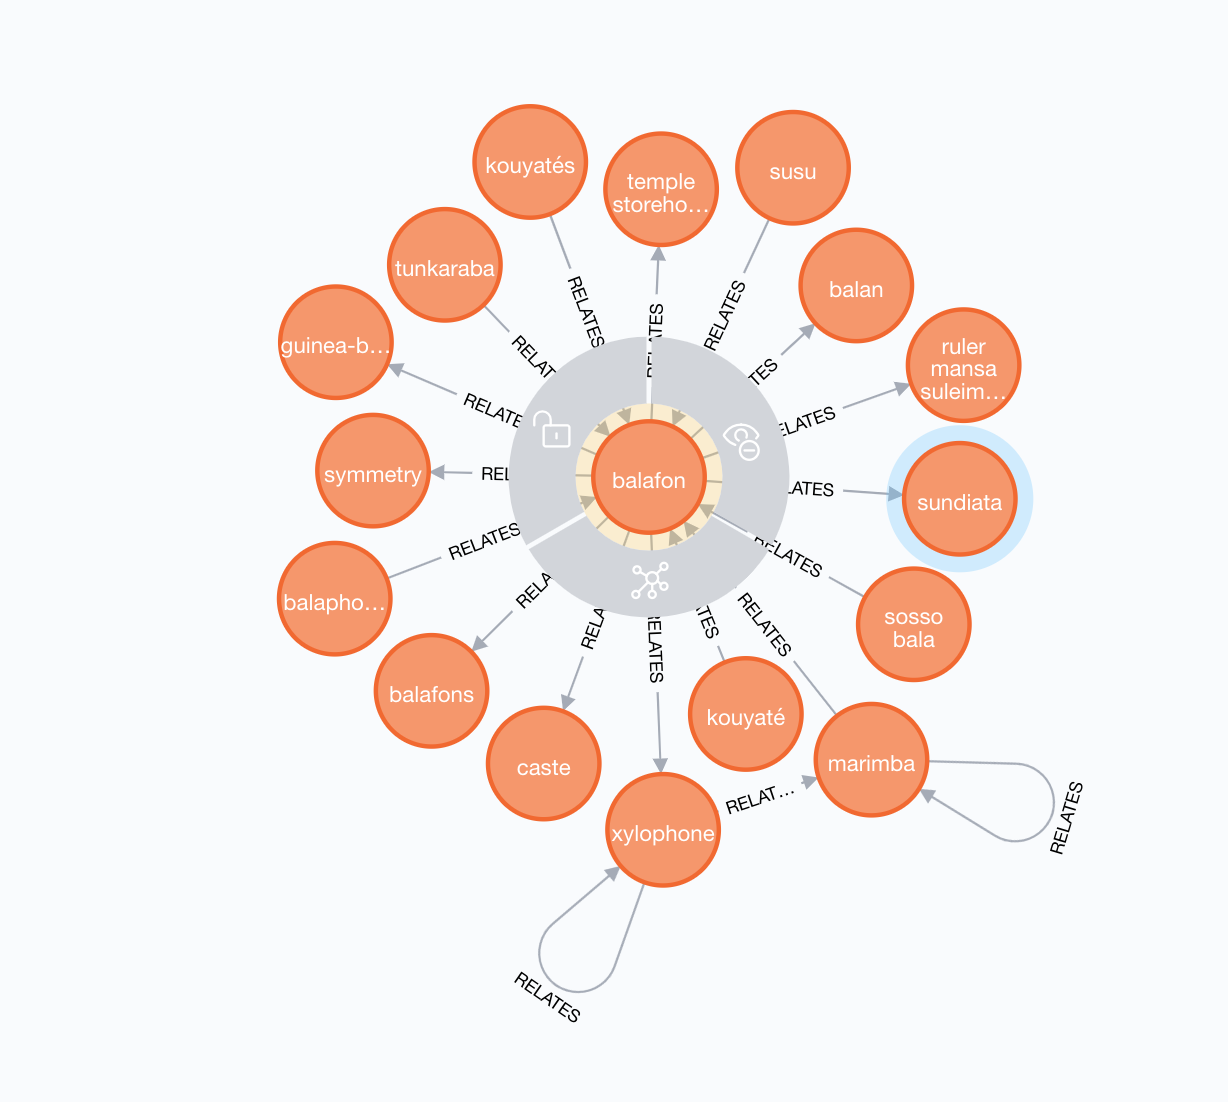

In [385]:
from IPython.display import Image
Image(filename='img/neo4j-balafon.png') 

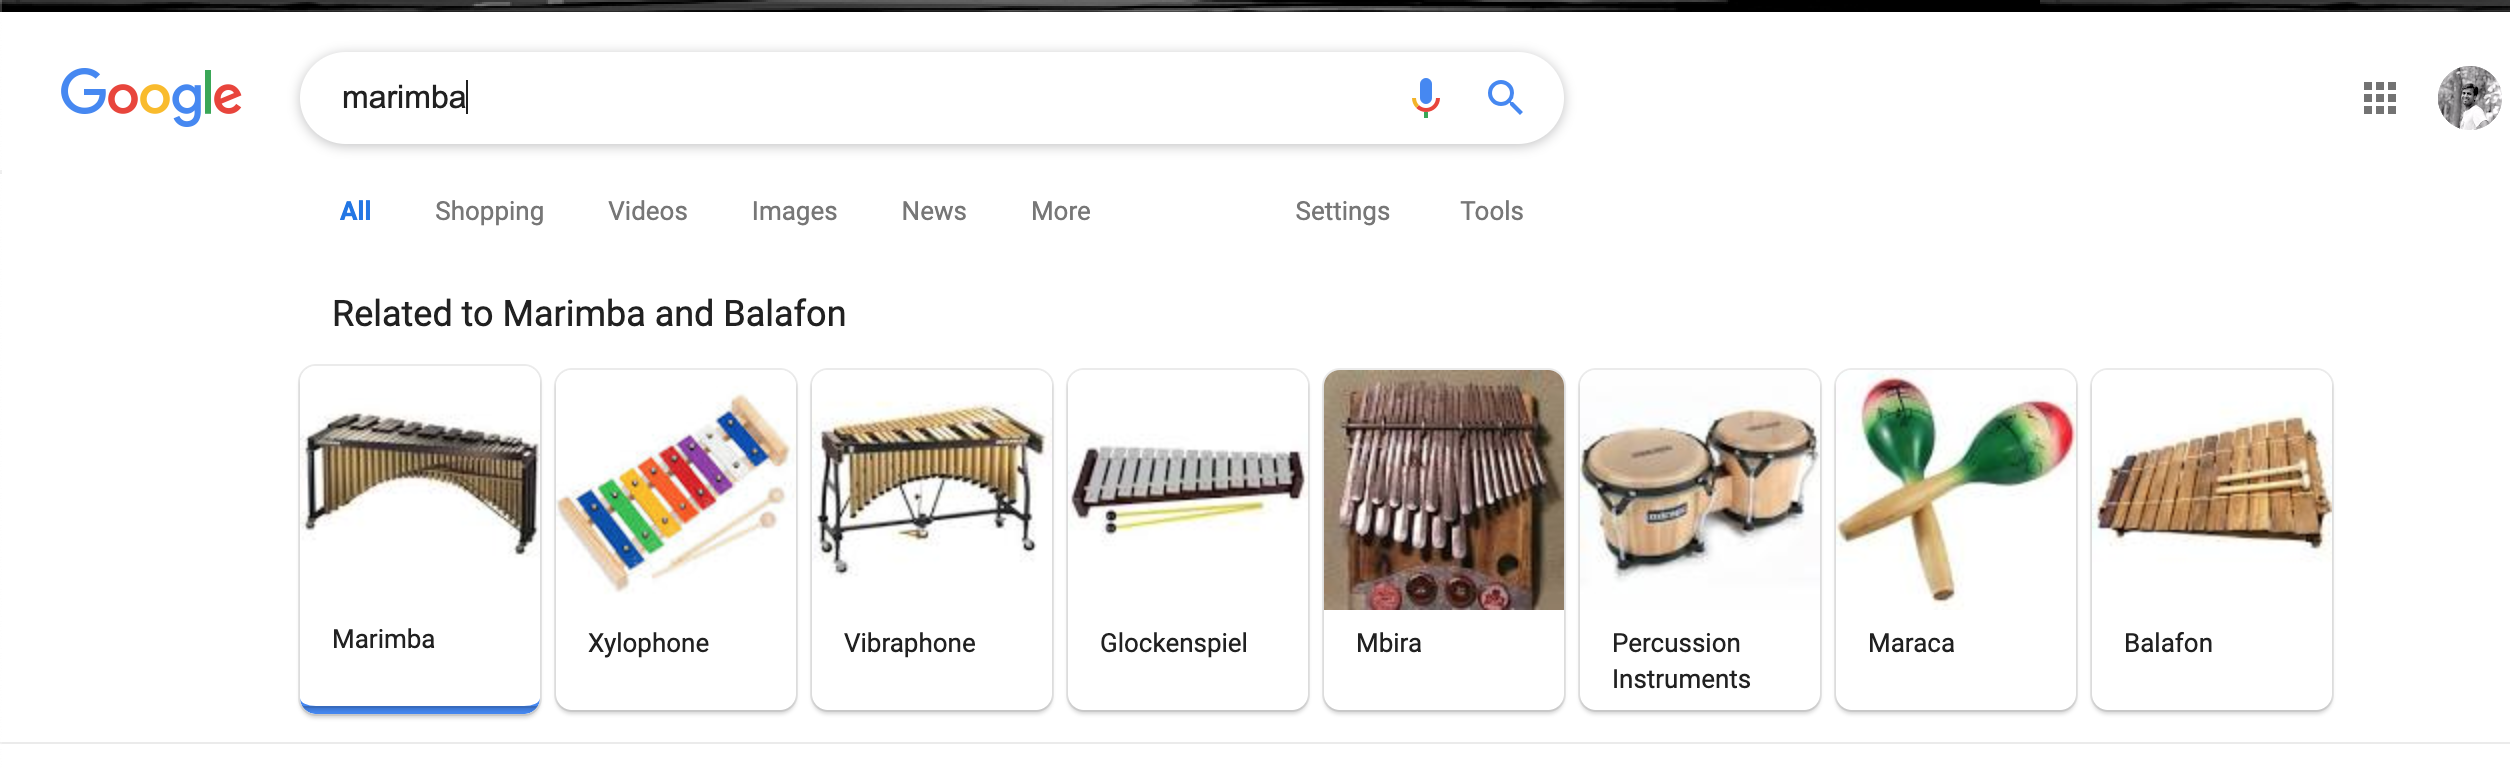

In [387]:
Image(filename='img/google-balafon.png') 

It can be clearly seen that "marimba" and "xylophone". The relationships were extracted using NLTK that looked at phrases with "of"/"at"/"is".